In [2]:
# importing required libraries
import lightgbm as lgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import json

In [3]:
# Read the data from the CSV file
df = pd.read_csv("../data/raw/domestic.csv")

/var/folders/f9/vl5q5h8x03zc5d261vg1p0gm0000gn/T/ipykernel_97881/1700538135.py:2: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/raw/domestic.csv")


**Data Cleaning**

In [4]:
# Remove unnecessary columns
df.drop(
    columns=[
        "citymarketid_1",
        "citymarketid_2",
        "airportid_1",
        "airportid_2",
        "fare_lg",
        "fare_low",
        "Geocoded_City1",
        "Geocoded_City2",
        "tbl",
        "tbl1apk",
        "passengers",
        "large_ms",
        "lf_ms"
        ],
    inplace=True,
)

In [5]:
# Rename columns

df.rename(
    columns={
        "Year": "year",
        "quarter": "quarter",
        "nsmiles": "distance"
    },
    inplace=True,
)

In [6]:
# Removing Nan values
df = df.dropna()

In [7]:
# Removing duplicate values
df = df.drop_duplicates()

In [8]:
# Remove outliers (IQR)
numeric_cols = df.select_dtypes(include=["number"]).columns.drop(["year", "quarter", "fare"])
Q1 = df[numeric_cols].quantile(0.25, numeric_only=True)
Q3 = df[numeric_cols].quantile(0.75, numeric_only=True)
IQR = Q3 - Q1


df = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

**EDA**

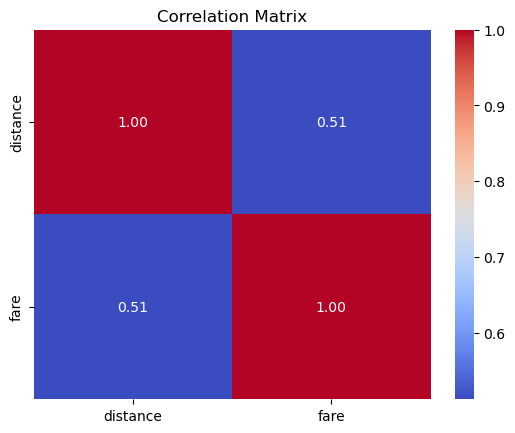

In [9]:
# Correlation Matrix of Quantitative Features
numeric_df = df.select_dtypes(include=["number"]).drop(columns=["year", "quarter"])

correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

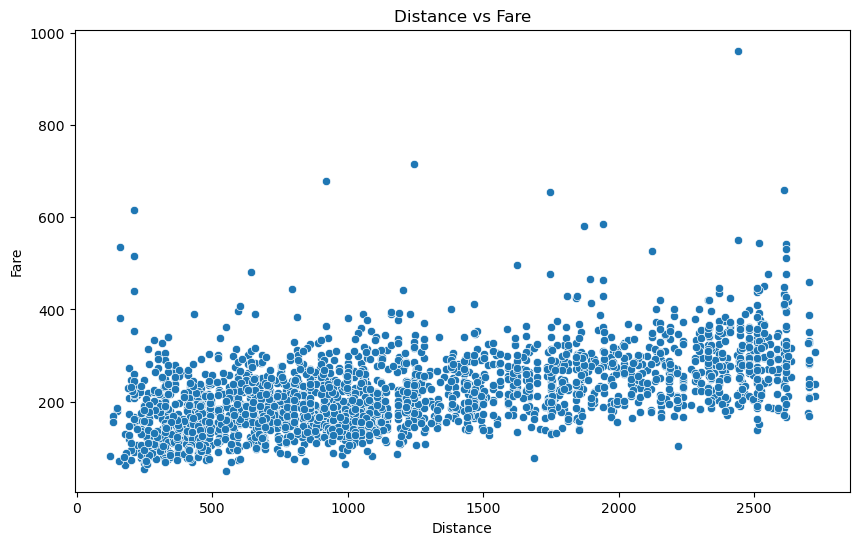

In [10]:
# Distance vs Fare
df_sample = df.sample(frac=0.01, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sample, x="distance", y="fare")
plt.title("Distance vs Fare")
plt.xlabel("Distance")
plt.ylabel("Fare")
plt.show()

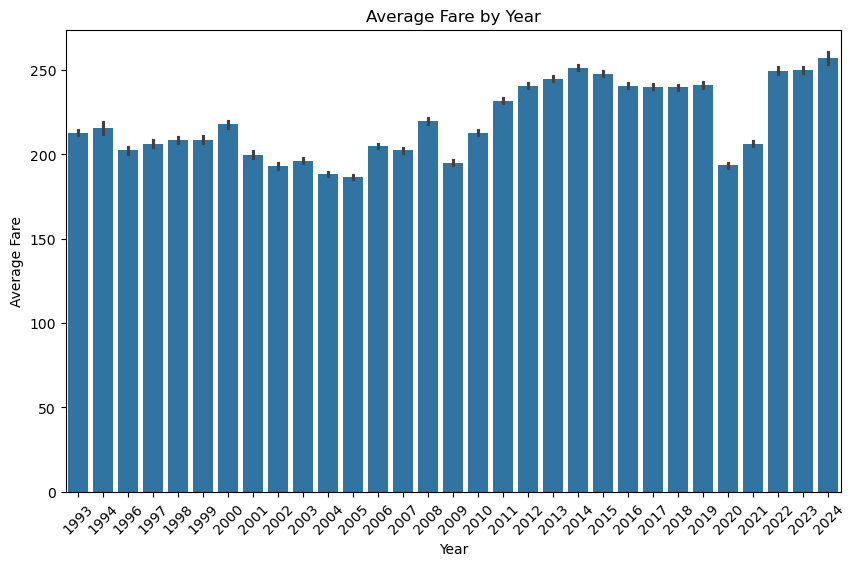

In [11]:
# Year and Average Fare Bar Graph
plt.figure(figsize=(10, 6))
sns.barplot(x="year", y="fare", data=df)
plt.title("Average Fare by Year")
plt.xlabel("Year")
plt.ylabel("Average Fare")
plt.xticks(rotation=45)
plt.show()


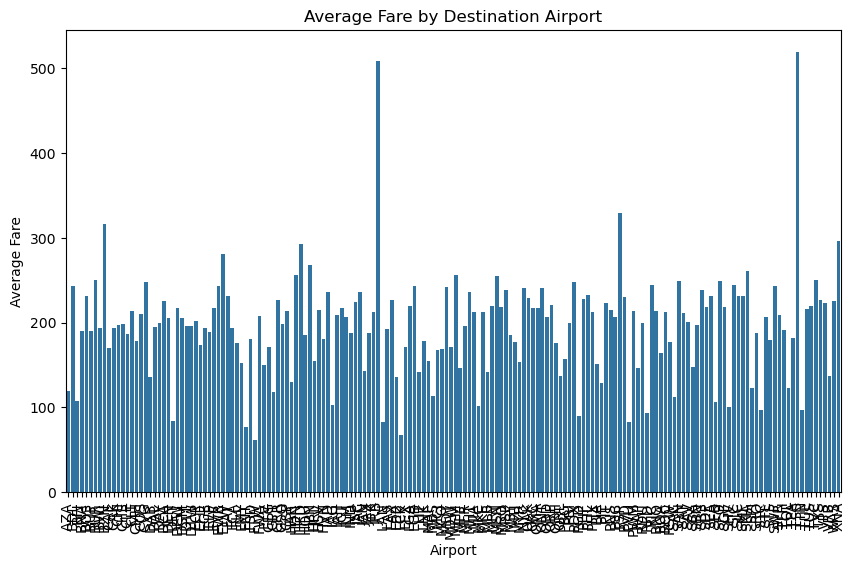

In [12]:
# Grouping by Destination Airport and Calculating Average Fare
df_grouped = df.groupby("airport_2", as_index=False)["fare"].mean()

# Destination Airport and Average Fare Bar Graph
plt.figure(figsize=(10, 6))
sns.barplot(x="airport_2", y="fare", data=df_grouped)
plt.title("Average Fare by Destination Airport")
plt.xlabel("Airport")
plt.ylabel("Average Fare")
plt.xticks(rotation=90)
plt.show()

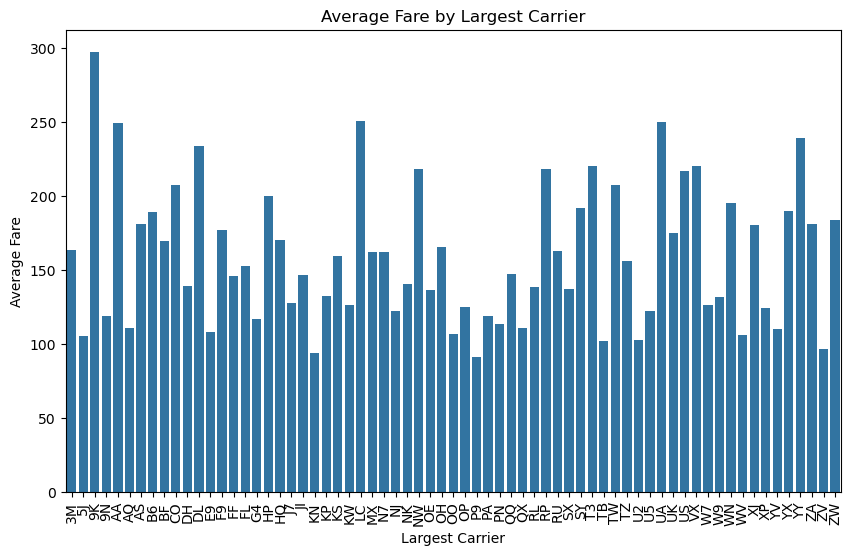

In [13]:
# Grouping by Large Carrier and Calculating Average Fare
df_grouped = df.groupby("carrier_lg", as_index=False)["fare"].mean()

# Large Carrier and Average Fare Bar Graph
plt.figure(figsize=(10, 6))
sns.barplot(x="carrier_lg", y="fare", data=df_grouped)
plt.title("Average Fare by Largest Carrier")
plt.xlabel("Largest Carrier")
plt.ylabel("Average Fare")
plt.xticks(rotation=90)
plt.show()

**Feature Engineering**

In [14]:
# Creating Route Variable
df["route"] = df[["airport_1", "airport_2"]].agg("-".join, axis=1)

In [15]:
# Removing unnecessary columns
df.drop(columns=["city1", "city2"], inplace=True)

In [16]:
# Determine which columns are categorical
categorical_columns = [
    "airport_1",
    "airport_2",
    "carrier_lg",
    "carrier_low",
    "quarter",
    "year",
    "route"
]

**Light Gradient Boosting Model**

In [17]:
# Create input and output variables
X = df.drop(columns=["fare"])
y = df["fare"]

In [18]:
# Convert DataFrame to a dictionary
df.drop(columns=["fare"], inplace=True)  # Drop target variable for encoding
df_encoded = df.to_dict(orient="records")  # Convert rows to a list of dictionaries

# Save to JSON file
with open("../data/processed/df_encoded.json", "w") as json_file:
    json.dump(df_encoded, json_file, indent=4)

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

X_train[categorical_columns] = X_train[categorical_columns].astype("category")
X_test[categorical_columns] = X_test[categorical_columns].astype("category")

**10-Fold Cross-Validation Hyperparameter Tuning with Randomized Search**

In [20]:
# LightGBM Model Hyperparameter Tuning
# model = lgb.LGBMRegressor()

# param_dist = {
#     "num_leaves": [50, 70, 100],
#     "max_depth": [-1, 10, 20],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "n_estimators": [100, 200, 500],
#     "subsample": [0.6, 0.8, 1.0],
#     "colsample_bytree": [0.6, 0.8, 1.0],
#     "min_child_samples": [10, 20, 30],
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     scoring="neg_mean_squared_error",
#     n_iter=20,
#     cv=10,
#     n_jobs=-1,
#     verbose=1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# best_params = random_search.best_params_

# # Best parameters from Random Search
# best_params = random_search.best_params_
# best_model = random_search.best_estimator_


In [21]:
# Re-train on 90% of the data with the best parameters
model = lgb.LGBMRegressor(
    subsample=1.0,
    num_leaves=70,
    n_estimators=500,
    min_child_samples=20,
    max_depth=20,
    learning_rate=0.1,
    colsample_bytree=0.8,
)
model.fit(X_train, y_train)



[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3769
[LightGBM] [Info] Number of data points in the train set: 232125, number of used features: 8
[LightGBM] [Info] Start training from score 218.459539


LGBMRegressor(colsample_bytree=0.8, max_depth=20, n_estimators=500,
              num_leaves=70)

In [22]:
# Make predictions
y_pred = model.predict(X_test)

**Evaluating Model**

In [23]:
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [24]:
# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 20.6243
Root Mean Squared Error (RMSE): 1250.1185
R-squared (R2): 0.7979


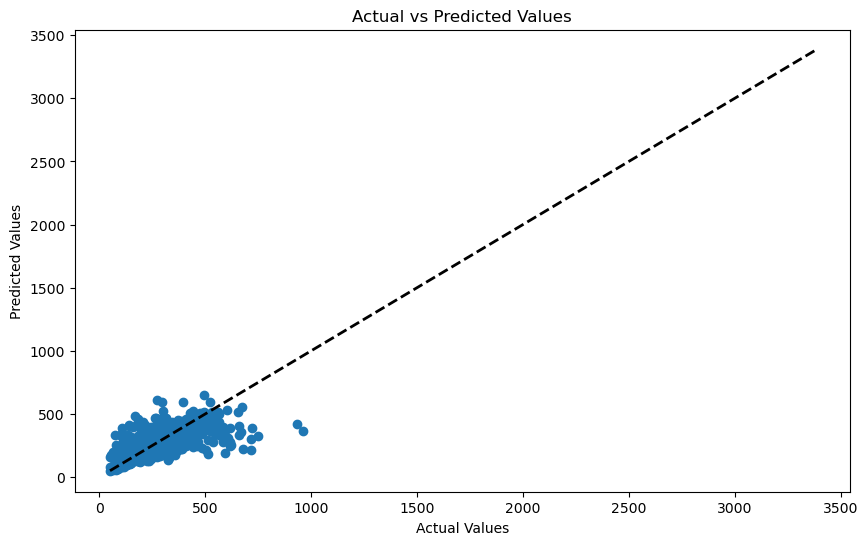

In [25]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.show()

In [26]:
# Save ML model
import joblib

# joblib.dump(best_rf, "../rf_model.pkl")

# Save the best model
joblib.dump(model, "../models/lgb_model.pkl")

['../models/lgb_model.pkl']